# Introduction

This document is the data analysis to create an analytical model between position and cv coordinates in the image.

In [2]:
import re
import pandas as pd
from src.computervision import load_img_from_file, ObjectDetection, MODEL_WEIGTS_DIR_DRACO
from os import listdir
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt

img_dir = "C:\\Users\\alvar\\University of Southampton\\GDP - Control System\\pictures"
iters = 1

def regex(input_comment: str) -> (float, float, float):
    result = re.search(r"d([0-9]+)h([0-9-]+)p([0-9]+)r?([0-9]*).jpg", input_comment)
    return result.group(1), result.group(2), result.group(3), result.group(4)


def post_process(cv: ObjectDetection, filename: str) -> (float, float, float, float):
    img = load_img_from_file(join(img_dir, filename))
    leaders = cv.process(img)

    if len(leaders) > 0:
        leader = leaders[0]

        return leader.confidence, leader.width_non_dimensional, leader.height_non_dimensional, leader.center_x_non_dimensional

    print(f"Failed to find leader in {filename}")
    return None, None, None, None

In [3]:
cv = ObjectDetection(MODEL_WEIGTS_DIR_DRACO)

# Get all file names of images
files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))]

# Remove the file names that don't match the structure
condition = re.compile(r'd[0-9]+h[0-9-]+p[0-9]+r?[0-9]*.jpg')
img = [s for s in files if condition.match(s)]

# Load the filenames into Pandas dataframe
data = pd.DataFrame()

data["filename"] = img * iters

data["distance"], data["yaw"], data["pitch"], data["resolution"] = zip(*data["filename"].map(regex))

# Iterate over pandas dataframe to determine the values of pixels with respect to angles and distances
data["confidence"], data["width_nd"], data["height_nd"], data["center_x_nd"] = zip(*data["filename"].map(lambda x: post_process(cv, x)))

data.to_csv("output.csv")

# Data post processing
data["area"] = data["width_nd"] * data["height_nd"]

Failed to find leader in d10h-10p0.jpg
Failed to find leader in d10h-2p0.jpg
Failed to find leader in d10h-4p0.jpg
Failed to find leader in d10h-6p0.jpg
Failed to find leader in d10h-8p0.jpg
Failed to find leader in d10h0p5.jpg
Failed to find leader in d10h10p0.jpg
Failed to find leader in d10h2p0.jpg
Failed to find leader in d10h4p0.jpg
Failed to find leader in d10h6p0.jpg
Failed to find leader in d10h8p0.jpg
Failed to find leader in d3h-10p0r1080.jpg
Failed to find leader in d4h-2p0r1080.jpg
Failed to find leader in d4h-6p0r1080.jpg
Failed to find leader in d7h-6p0r1080.jpg
Failed to find leader in d7h-8p0r1080.jpg
Failed to find leader in d7h0p0r1080.jpg
Failed to find leader in d7h10p0r1080.jpg
Failed to find leader in d7h2p0r1080.jpg
Failed to find leader in d7h4p0r1080.jpg
Failed to find leader in d7h6p0r1080.jpg
Failed to find leader in d7h8p0r1080.jpg
Failed to find leader in d8h-10p0r1080.jpg
Failed to find leader in d8h-2p0r1080.jpg
Failed to find leader in d8h-4p0r1080.jpg
F

## Filter the post process data to get rid of the NaN values that cannot be post processed

In [4]:
complete_data = data[data["width_nd"].notnull()]

In [5]:
# Curve fitting and noise function

class linear_poly:
    m = 0
    c = 0

distance = linear_poly()
[distance.m, distance.c] = np.polyfit(complete_data["distance"].astype(float).to_numpy(), complete_data["area"].to_numpy(), 1)

yaw = linear_poly()
[yaw.m, yaw.c] = np.polyfit(complete_data["yaw"].astype(float).to_numpy(), complete_data["center_x_nd"].to_numpy(), 1)

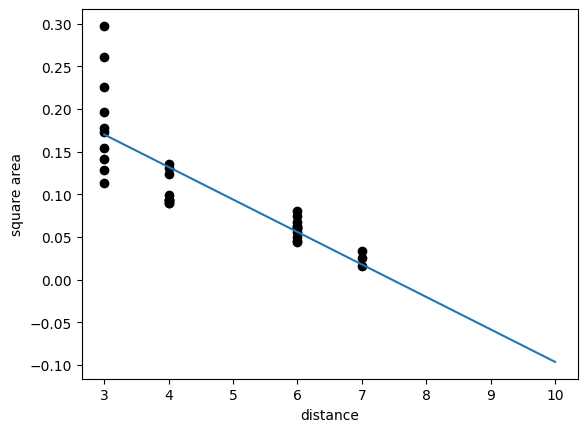

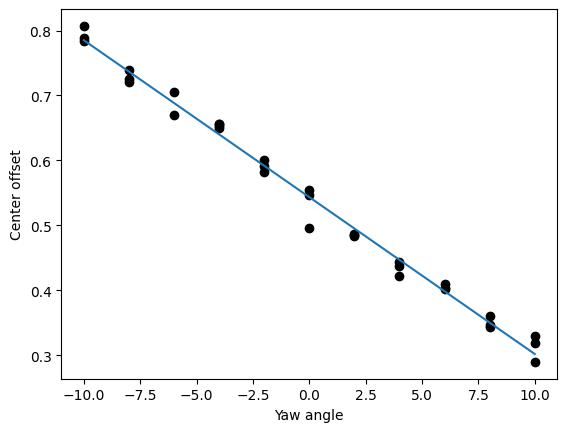

In [6]:
distance_placeholder = np.linspace(min(data["distance"].astype(float)), max(data["distance"].astype(float)))

plt.scatter(data["distance"].astype(float), data["area"], color="black")
plt.plot(distance_placeholder, distance.m * distance_placeholder + distance.c)
plt.xlabel("distance")
plt.ylabel("square area")
plt.show()


yaw_placeholder = np.linspace(min(data["yaw"].astype(float)), max(data["yaw"].astype(float)))
plt.plot(yaw_placeholder, yaw.m * yaw_placeholder + yaw.c)
plt.scatter(data["yaw"].astype(float), data["center_x_nd"], color="black")
plt.xlabel("Yaw angle")
plt.ylabel("Center offset")
plt.show()

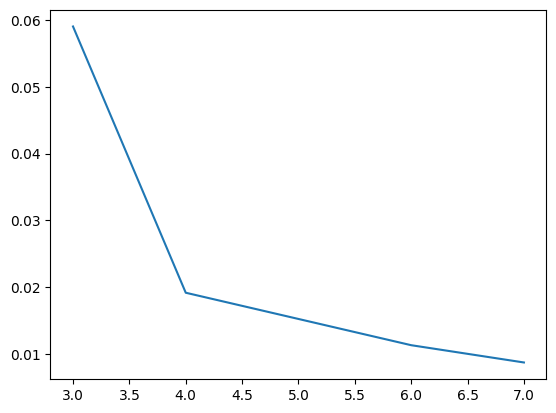

In [7]:
# Determining the standard deviation
distances = complete_data["distance"].astype(float).unique()

distances.sort()

std = np.zeros(len(distances))

for inx, i in enumerate(distances):
    std[inx] = complete_data[i == complete_data["distance"].astype(float)]["area"].std()

plt.plot(distances, std)